In [1]:
from tqdm import tqdm
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pipeline import load_index_paths
from utils import get_images_percentiles

from sklearn.decomposition import PCA
# from sklearn.decomposition import SparsePCA as PCA
from sklearn.preprocessing import StandardScaler
from data_viz import save_image_grid
import torch


import utils
utils.silent = True

In [2]:
# data_folder = Path("/data/ishang/FUCCI-dataset-well/")
# index_file = "index_clean_no_border_rm_1000_sharp_1250.csv"
# channel_slice = slice(0, 4)
data_folder = Path("/data/ishang/HPA-CC-dataset/")
NAME = "512_min_max"
channel_slice = slice(0, 3)
index_file = f"index_{NAME}.csv"
# channel_names = ["DAPI", "TUBL", "GMNN", "CDT1"]
channel_names = ["DAPI", "TUBL", "ER"]
index_path = data_folder / index_file

eval_percentiles = [0, 1, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 75, 80, 85, 90, 95, 99, 100]
resolution = 8 # bit
buckets = 2 ** resolution
eval_percentiles = np.array(list(range(0, buckets, 1))) / (buckets - 1) * 100
print(eval_percentiles)

image_paths, mask_paths, _ = load_index_paths(index_path)
percentiles_path = data_folder / f"well_percentiles_{buckets}.npy"

[  0.           0.39215686   0.78431373   1.17647059   1.56862745
   1.96078431   2.35294118   2.74509804   3.1372549    3.52941176
   3.92156863   4.31372549   4.70588235   5.09803922   5.49019608
   5.88235294   6.2745098    6.66666667   7.05882353   7.45098039
   7.84313725   8.23529412   8.62745098   9.01960784   9.41176471
   9.80392157  10.19607843  10.58823529  10.98039216  11.37254902
  11.76470588  12.15686275  12.54901961  12.94117647  13.33333333
  13.7254902   14.11764706  14.50980392  14.90196078  15.29411765
  15.68627451  16.07843137  16.47058824  16.8627451   17.25490196
  17.64705882  18.03921569  18.43137255  18.82352941  19.21568627
  19.60784314  20.          20.39215686  20.78431373  21.17647059
  21.56862745  21.96078431  22.35294118  22.74509804  23.1372549
  23.52941176  23.92156863  24.31372549  24.70588235  25.09803922
  25.49019608  25.88235294  26.2745098   26.66666667  27.05882353
  27.45098039  27.84313725  28.23529412  28.62745098  29.01960784
  29.411764

In [3]:
if percentiles_path.exists():
    well_percentiles = np.load(percentiles_path)
if not percentiles_path.exists() or well_percentiles.shape[-1] != len(eval_percentiles):
    well_percentiles = []
    for image_path, mask_path in tqdm(zip(image_paths, mask_paths), total=len(image_paths), desc="Calculating well percentiles"):
        if image_path.suffix == ".pt":
            image = torch.load(image_path).numpy()
        else:
            image = np.load(image_path)
        mask_path = str(mask_path)
        if mask_path.endswith(".pt"):
            mask = torch.load(mask_path)[:, None, ...].numpy()
        else:
            mask_path = mask_path + ".npy"
            mask = np.load(mask_path)[:, None, ...]
        image = image * (mask > 0)
        values, percentiles = get_images_percentiles(image, percentiles=eval_percentiles, non_zero=True)
        assert (values > 0).all(), "Values should be positive"
        well_percentiles.append(values)

    well_percentiles = np.array(well_percentiles) # W x C x P

    np.save(data_folder / f"well_percentiles_{buckets}.npy", well_percentiles)

Calculating well percentiles: 100%|██████████| 30/30 [00:12<00:00,  2.44it/s]


<Figure size 640x480 with 0 Axes>

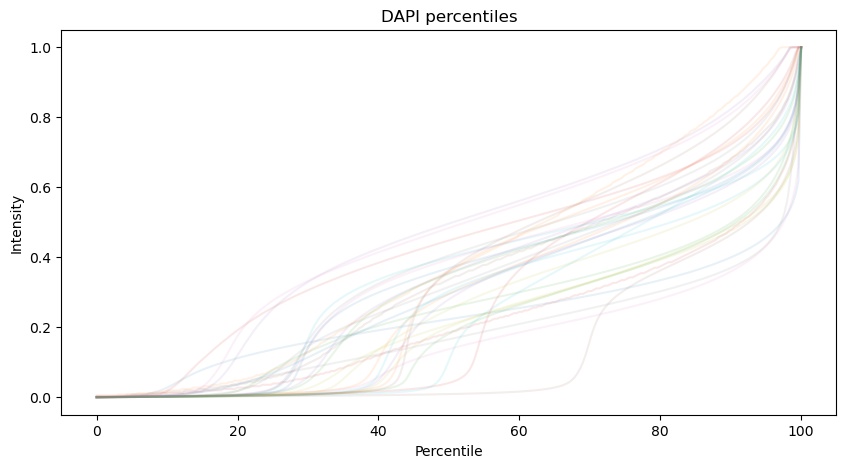

<Figure size 640x480 with 0 Axes>

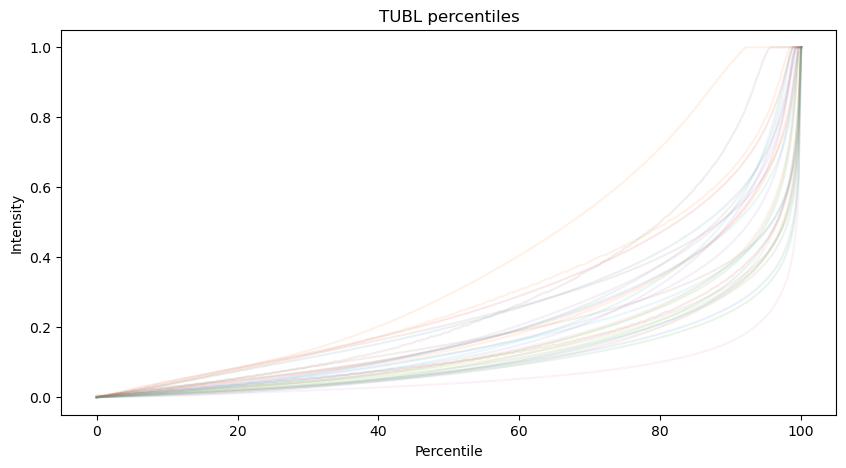

<Figure size 640x480 with 0 Axes>

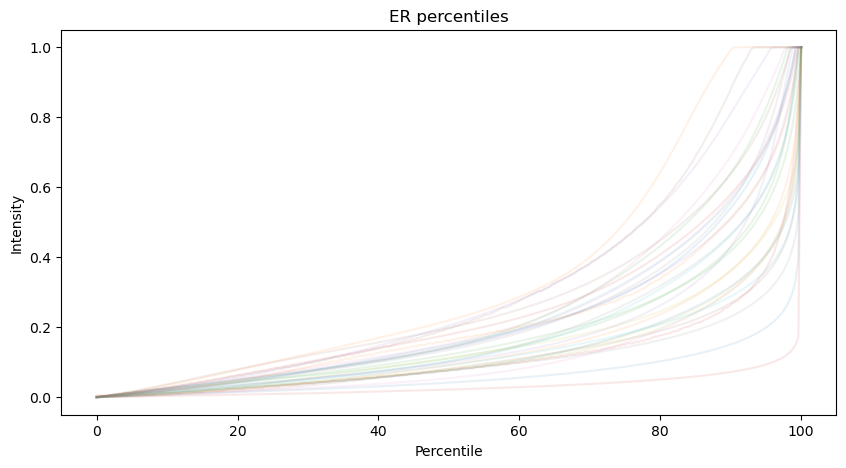

In [4]:
# plot well_percentiles per channel
for i, c in enumerate(channel_names):
    plt.clf()
    plt.figure(figsize=(10, 5))
    plt.plot(eval_percentiles, well_percentiles[:, i, :].T, alpha=0.1)
    plt.title(f"{c} percentiles")
    plt.xlabel("Percentile")
    plt.ylabel("Intensity")
    # plt.savefig(f"percentiles_{c}.png", dpi=300)
    plt.show()

In [5]:
plot_percentiles = [0, 10, 25, 50, 75, 90, 95, 99, 100]
plot_percentile_indices = np.where(eval_percentiles.astype(int).astype(eval_percentiles.dtype) == eval_percentiles)
plot_percentiles = np.array(eval_percentiles)[plot_percentile_indices]
print(plot_percentiles)
plot_well_percentiles = well_percentiles.transpose(1, 0, 2) # C x W x P
plot_well_percentiles = plot_well_percentiles[:, :, plot_percentile_indices]

[  0.  20.  40.  60.  80. 100.]


/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

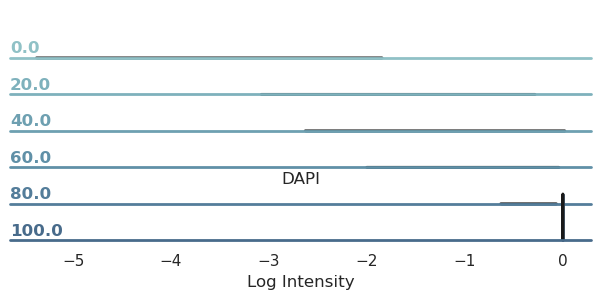

/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plo

<Figure size 640x480 with 0 Axes>

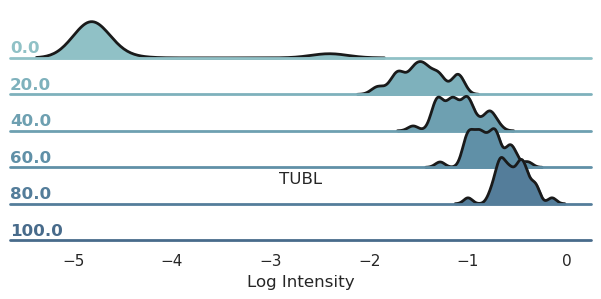

/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plo

<Figure size 640x480 with 0 Axes>

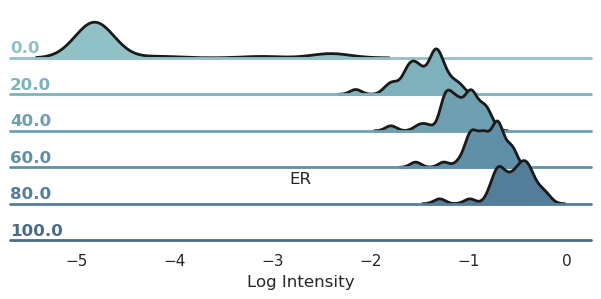

In [6]:
def channel_ridgeplots(percentile_values, log=True):
    df_percentiles = np.tile(plot_percentiles, (percentile_values.shape[1],)) # W * P
    for j, channel in enumerate(channel_names):
        plt.clf()
        sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
        values = percentile_values[j].flatten()
        x_axis_label = "Log Intensity" if log else "Intensity"
        x_values = np.log10(values) if log else values
        df = pd.DataFrame({"Percentile": df_percentiles, x_axis_label: x_values})
        
        # Initialize the FacetGrid object
        pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
        g = sns.FacetGrid(df, row="Percentile", hue="Percentile", aspect=15, height=.5, palette=pal)

        # Draw the density plot and a contour around it
        g.map(sns.kdeplot, x_axis_label,
            bw_adjust=.5, clip_on=False,
            fill=True, alpha=1, linewidth=1.5)
        g.map(sns.kdeplot, x_axis_label, clip_on=False, color="k", lw=2, bw_adjust=.5)

        # passing color=None to refline() uses the hue mapping
        g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


        # Define and use a simple function to label the plot in axes coordinates
        def label(x, color, label):
            ax = plt.gca()
            ax.text(0, .2, label, fontweight="bold", color=color,
                    ha="left", va="center", transform=ax.transAxes)


        g.map(label, x_axis_label)

        # Set the subplots to overlap
        g.figure.subplots_adjust(hspace=-.25)

        # Remove axes details that don't play well with overlap
        g.set_titles("")
        g.set(yticks=[], ylabel="")
        g.despine(bottom=True, left=True)

        # plt.tight_layout()
        plt.title(channel)
        plt.show()
channel_ridgeplots(plot_well_percentiles)

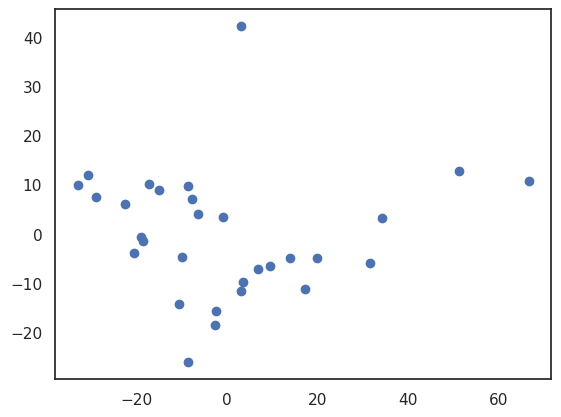

Explained variance ratio: [0.51546181 0.15679735 0.12471954 0.09665969 0.03034067 0.01763754
 0.01307637 0.01119722 0.00895939 0.00555041 0.00406706 0.0032889
 0.00227475 0.00222232 0.00205417]


In [7]:
# PCA of well percentiles
def percentiles_PCA(well_percentiles, color=None):
    well_percentiles = well_percentiles.reshape(well_percentiles.shape[0], -1) # W x (C * P)
    scaler = StandardScaler()
    scaled_well_percentiles = scaler.fit_transform(well_percentiles)
    pca = PCA(n_components=15)
    well_pca = pca.fit_transform(scaled_well_percentiles)
    plt.clf()
    if color is None:
        plt.scatter(well_pca[:, 0], well_pca[:, 1])
    else:
        plt.scatter(well_pca[:, 0], well_pca[:, 1], c=color)
    plt.show()

    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    return pca, scaler

pca, scaler = percentiles_PCA(well_percentiles)
# print the top pc in terms of the original features
top_pc = pca.components_[0]
top_pc = top_pc.reshape(4, -1) # C x P

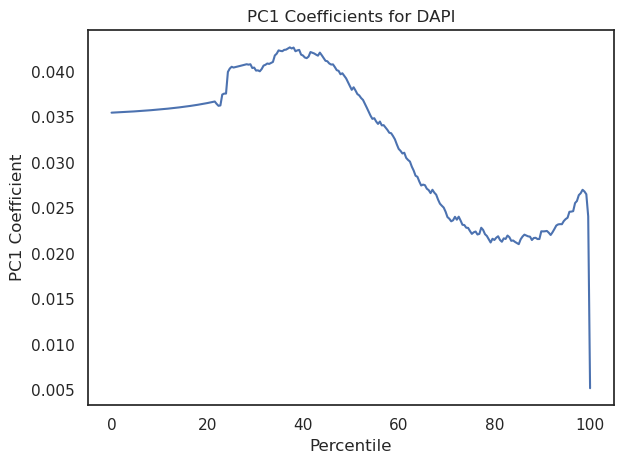

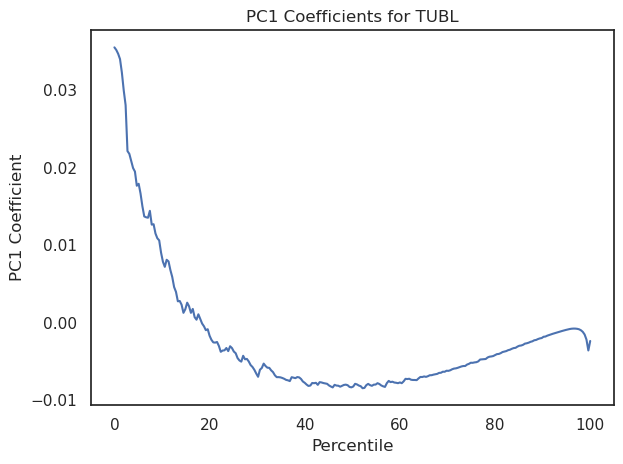

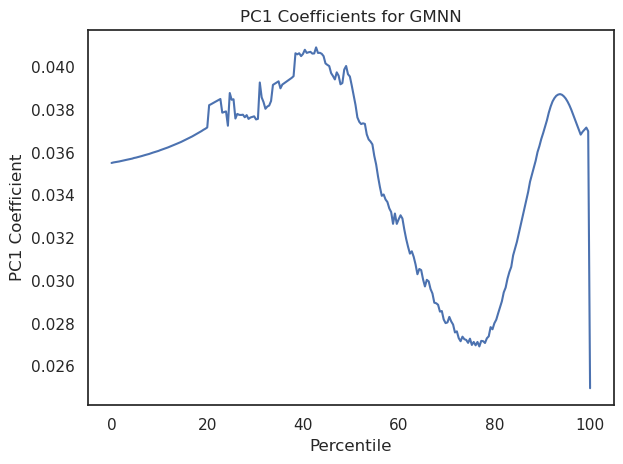

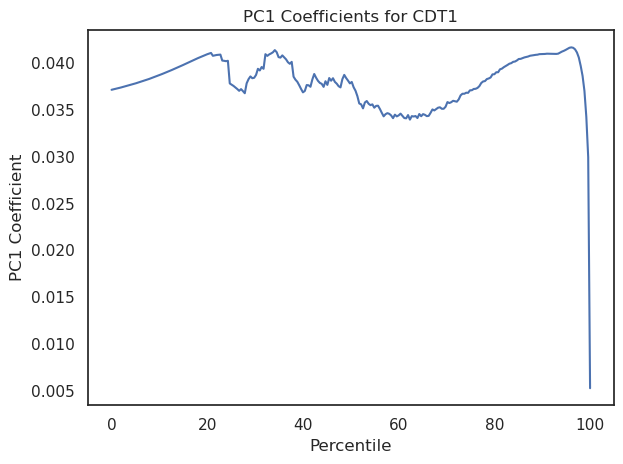

In [27]:
# plot the top pc for each channel
for j, channel in enumerate(channel_names):
    plt.clf()
    plt.plot(eval_percentiles, top_pc[j])
    plt.xlabel("Percentile")
    plt.ylabel("PC1 Coefficient")
    plt.title(f"PC1 Coefficients for {channel}")
    plt.tight_layout()
    plt.show()



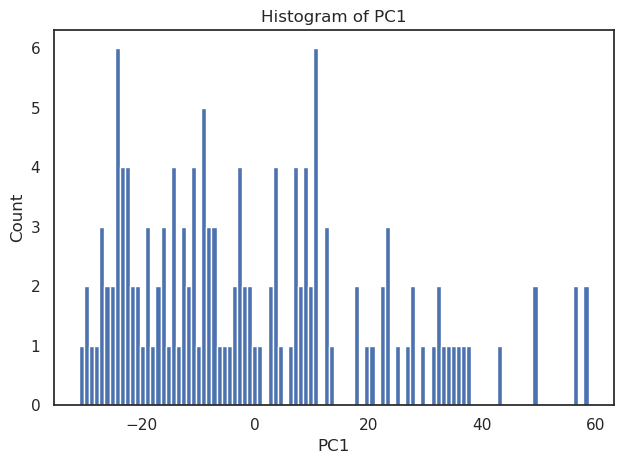

In [28]:
# plot PCA as histogram along the first PC
plt.clf()
well_pca = pca.transform(scaler.transform(well_percentiles.reshape(well_percentiles.shape[0], -1)))
plt.hist(well_pca[:, 0], bins=100)
plt.xlabel("PC1")
plt.ylabel("Count")
plt.title("Histogram of PC1")
plt.tight_layout()
plt.show()



/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


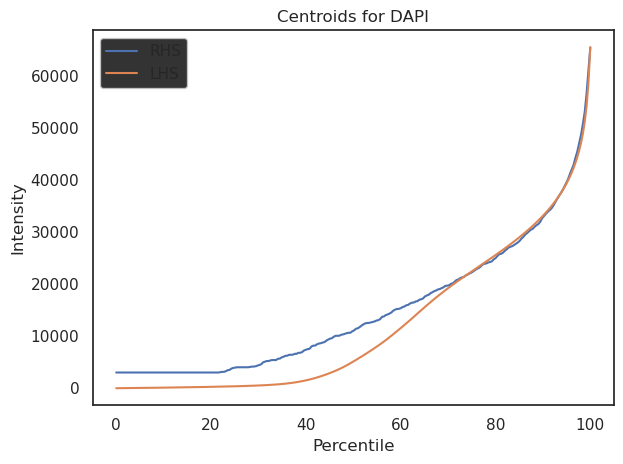

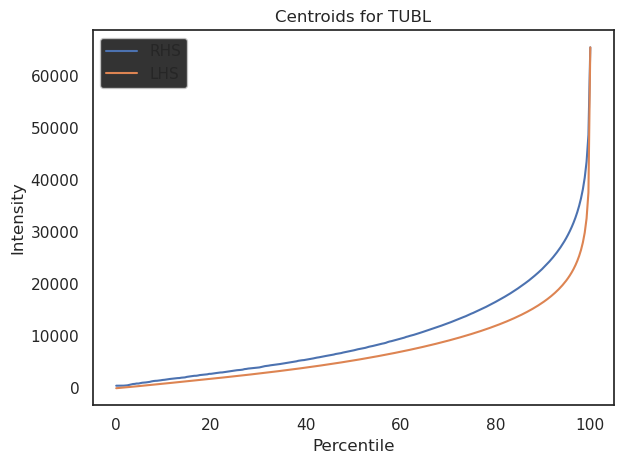

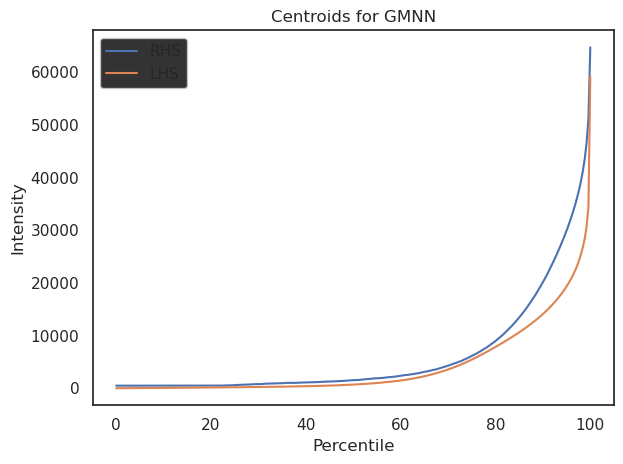

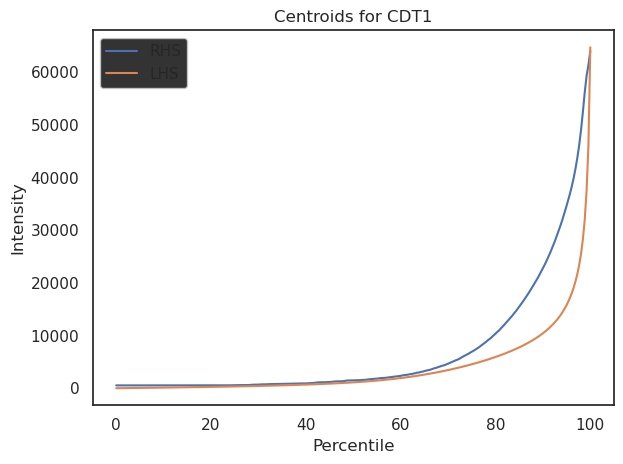

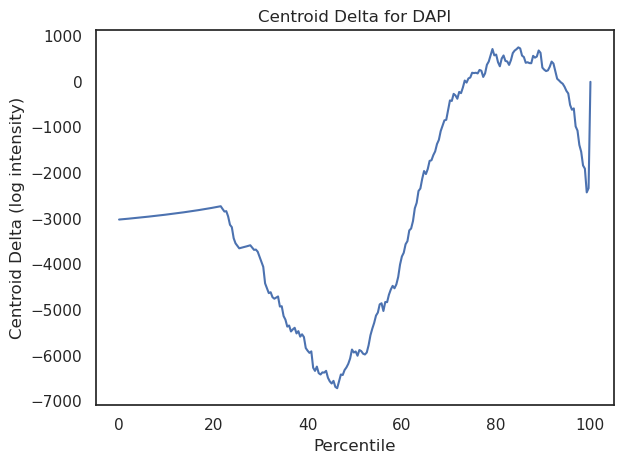

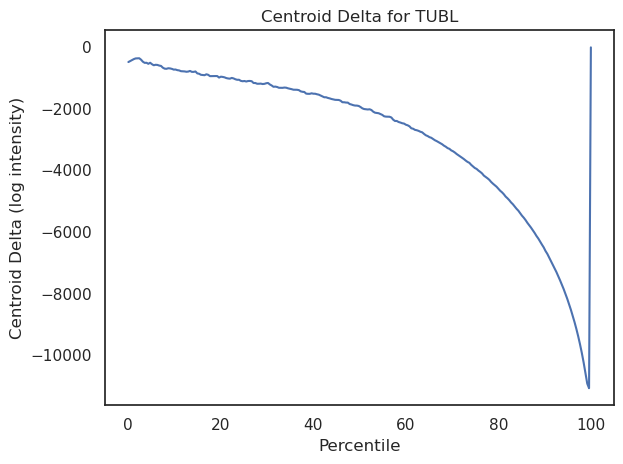

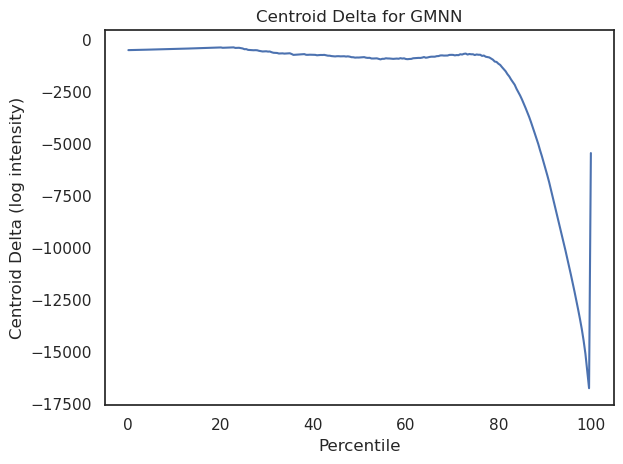

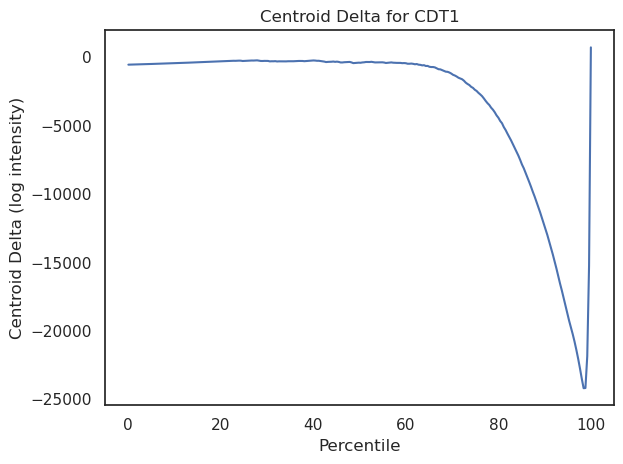

In [29]:
# fit k-means on the first two PCs
from sklearn.cluster import KMeans
def kmeans_PCA(well_pca, pca, scaler):
    kmeans = KMeans(n_clusters=2).fit(well_pca)

    # pass centroids backwards through the pca and standard scaler to get the delta in the original feature space
    RHS_centroid = kmeans.cluster_centers_[0] if kmeans.cluster_centers_[0, 0] > kmeans.cluster_centers_[1, 0] else kmeans.cluster_centers_[1]
    LHS_centroid = kmeans.cluster_centers_[0] if kmeans.cluster_centers_[0, 0] <= kmeans.cluster_centers_[1, 0] else kmeans.cluster_centers_[1]

    def centroid_to_intensity(c, pca, scaler):
        padded_vector = np.zeros((pca.n_components_,))
        padded_vector[:len(c)] = c
        c = padded_vector.reshape(1, -1)
        c = pca.inverse_transform(c)
        c = scaler.inverse_transform(c)
        c = c.reshape(4, -1) # C x P
        return c

    RHS_centroid = centroid_to_intensity(RHS_centroid, pca, scaler)
    LHS_centroid = centroid_to_intensity(LHS_centroid, pca, scaler)

    # check if the centroids are valid percentiles
    for j, channel in enumerate(channel_names):
        plt.clf()
        plt.plot(eval_percentiles, RHS_centroid[j], label="RHS")
        plt.plot(eval_percentiles, LHS_centroid[j], label="LHS")
        plt.xlabel("Percentile")
        plt.ylabel("Intensity")
        plt.title(f"Centroids for {channel}")
        plt.legend()
        plt.tight_layout()
        plt.show()

    centroid_delta = LHS_centroid - RHS_centroid
    # print(f"Centroid delta: {centroid_delta}")

    def signed_log10(x):
        for i in range(len(x)):
            if x[i] == 0:
                x[i] = 0
            else:
                x[i] = np.sign(x[i]) * np.log10(np.abs(x[i]))
        return x

    # plot the centroid delta for each channel
    for j, channel in enumerate(channel_names):
        plt.clf()
        # plt.plot(eval_percentiles, signed_log10(centroid_delta[i]))
        plt.plot(eval_percentiles, centroid_delta[j])
        plt.xlabel("Percentile")
        plt.ylabel("Centroid Delta (log intensity)")
        plt.title(f"Centroid Delta for {channel}")
        plt.tight_layout()
        plt.show()

    return RHS_centroid, LHS_centroid, centroid_delta

RHS_centroid, LHS_centroid, centroid_delta = kmeans_PCA(well_pca, pca, scaler)

98 44


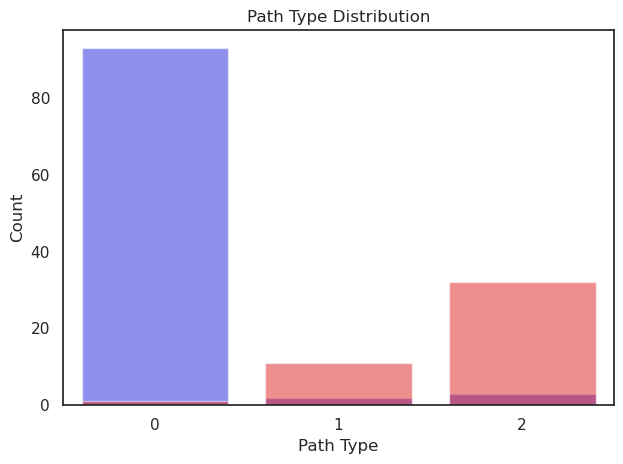

In [30]:
# sort the wells by centroid
LHC, RHC = [], []
LH_paths, RH_paths = [], []
path_types = {"chamber":0, "overview":1, "tilescan":2}
well_path_types = []
def path_to_type(path):
    for p in path_types.keys():
        if p in path:
            return path_types[p]
    return -1

for well, path in zip(well_percentiles, image_paths):
    well = well.reshape(4, -1) # C x P
    # if np.linalg.norm(well - LHS_centroid) < np.linalg.norm(well - RHS_centroid):
    if np.linalg.norm(well - LHS_centroid) < np.linalg.norm(well - RHS_centroid):
        LHC.append(well)
        LH_paths.append(path_to_type(str(path)))
    else:
        RHC.append(well)
        RH_paths.append(path_to_type(str(path)))
    well_path_types.append(path_to_type(str(path)))

print(len(LHC), len(RHC))

# plot the distribution of path types per cluster as an sns barchart
plt.clf()
sns.barplot(x=list(path_types.values()), y=[LH_paths.count(i) for i in path_types.values()], color="blue", alpha=0.5)
sns.barplot(x=list(path_types.values()), y=[RH_paths.count(i) for i in path_types.values()], color="red", alpha=0.5)
plt.xlabel("Path Type")
plt.ylabel("Count")
plt.title("Path Type Distribution")
plt.tight_layout()
plt.show()

In [31]:
# function to apply the centroid delta transform to a well
def apply_centroid_delta_RHS(well_percentiles, centroid_delta):
    clip_count = 0
    # well_percentiles is a single well here
    well_percentiles = well_percentiles.reshape(4, -1) # C x P
    assert well_percentiles.shape == centroid_delta.shape
    for i, channel in enumerate(channel_names):
        for p in range(len(eval_percentiles)):
            clipped = False
            well_percentiles[i, p] += centroid_delta[i, p]
            if p > 1 and well_percentiles[i, p] < well_percentiles[i, p - 1]:
                well_percentiles[i, p] = well_percentiles[i, p - 1]
                print(f"Clipping {channel} at percentile {eval_percentiles[p]} to {well_percentiles[i, p - 1]}")
                clipped = True
            if well_percentiles[i, p] < 0:
                well_percentiles[i, p] = 0
                print(f"Clipping {channel} at percentile {eval_percentiles[p]} to 0")
                clipped = True
            # almost all are subtractive so this shouldn't be needed
            # also why this is iterating from 0 to 100
            if well_percentiles[i, p] > np.iinfo(np.uint16).max:
                well_percentiles[i, p] = np.iinfo(np.uint16).max
                print(f"Clipping {channel} at percentile {eval_percentiles[p]} to {np.iinfo(np.uint16).max}")
                clipped = True
            clip_count += int(clipped)
    return well_percentiles, clip_count

def apply_centroid_delta_LHS(well_percentiles, centroid_delta):
    clip_count = 0
    well_percentiles = well_percentiles.reshape(4, -1) # C x P
    for i, channel in enumerate(channel_names):
        for p in range(len(eval_percentiles) - 1, -1, -1):
            clipped = False
            well_percentiles[i, p] += centroid_delta[i, p]
            if p < len(eval_percentiles) - 1 and well_percentiles[i, p] > well_percentiles[i, p + 1]:
                well_percentiles[i, p] = well_percentiles[i, p + 1]
                print(f"Clipping {channel} at percentile {eval_percentiles[p]} to {well_percentiles[i, p + 1]}")
                clipped = True
            if well_percentiles[i, p] > np.iinfo(np.uint16).max:
                well_percentiles[i, p] = np.iinfo(np.uint16).max
                print(f"Clipping {channel} at percentile {eval_percentiles[p]} to {np.iinfo(np.uint16).max}")
                clipped = True
            # almost all are additive so this shouldn't be needed
            # also why this is iterating from 100 to 0
            if well_percentiles[i, p] < 0:
                well_percentiles[i, p] = 0
                print(f"Clipping {channel} at percentile {eval_percentiles[p]} to 0")
                clipped = True
            clip_count += int(clipped)
    return well_percentiles, clip_count

In [32]:
transformed_well_percentiles = []
total_clipping = 0
total_transformed = 0
for cluster, well in zip(well_path_types, well_percentiles):
    # check if the well corresponds to the LHS or RHS cluster
    # only transform the ones closer to the RHS cluster
    # well_pca = pca.transform(scaler.transform(well.reshape(1, -1)))
    # dist_LHS, dist_RHS = np.sum(np.abs(well_pca[0, 0] - LHS_centroid[0])), np.sum(np.abs(well_pca[0, 0] - RHS_centroid[0]))
    # well_sq = well.reshape(4, -1)
    # dist_LHS, dist_RHS = np.linalg.norm(well_sq - LHS_centroid), np.linalg.norm(well_sq - RHS_centroid)
    # if dist_LHS > dist_RHS:
    if cluster > 0:
        transformed_well, clip_count = apply_centroid_delta_RHS(well, centroid_delta)
        # transformed_well, clip_count = apply_centroid_delta_RHS(well, centroid_delta * 0.5)
        total_clipping += clip_count
        total_transformed += 1
        transformed_well_percentiles.append(transformed_well)
    else:
        transformed_well_percentiles.append(well.reshape(4, -1))
        # transformed_well, clip_count = apply_centroid_delta_LHS(well, centroid_delta * -0.5)
        # total_clipping += clip_count
        # total_transformed += 1
        # transformed_well_percentiles.append(transformed_well)
transformed_well_percentiles = np.array(transformed_well_percentiles)
# transformed_well_percentiles = transformed_well_percentiles.transpose(1, 0, 2) # C x W x P
print(f"Total transformed: {total_transformed}")
print(f"Total clipping: {total_clipping}")
print(f"Portion Clipped: {total_clipping / (total_transformed * 4 * len(eval_percentiles))}")

# check all well percentiles are monotonically increasing
for well in transformed_well_percentiles:
    for j, channel in enumerate(channel_names):
        for p in range(len(eval_percentiles)):
            if p > 1 and well[j, p] < well[j, p - 1]:
                print(f"well {j} channel {channel} percentile {p} is smaller than percentile {p - 1}")

plot_transformed_well_percentiles = transformed_well_percentiles[:, :, plot_percentile_indices]

Clipping DAPI at percentile 21.96078431372549 to 295.49287420024757
Clipping DAPI at percentile 22.35294117647059 to 295.49287420024757
Clipping DAPI at percentile 22.745098039215687 to 295.49287420024757
Clipping DAPI at percentile 23.137254901960784 to 295.49287420024757
Clipping DAPI at percentile 23.52941176470588 to 295.49287420024757
Clipping DAPI at percentile 23.92156862745098 to 295.49287420024757
Clipping DAPI at percentile 24.313725490196077 to 295.49287420024757
Clipping DAPI at percentile 24.705882352941178 to 295.49287420024757
Clipping DAPI at percentile 25.098039215686274 to 295.49287420024757
Clipping DAPI at percentile 25.49019607843137 to 295.49287420024757
Clipping DAPI at percentile 25.882352941176475 to 295.49287420024757
Clipping DAPI at percentile 26.27450980392157 to 295.49287420024757
Clipping DAPI at percentile 26.666666666666668 to 295.49287420024757
Clipping DAPI at percentile 27.058823529411764 to 295.49287420024757
Clipping DAPI at percentile 27.450980392

Total transformed: 48
Total clipping: 20345
Portion Clipped: 0.4139200846354167


/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plo

<Figure size 640x480 with 0 Axes>

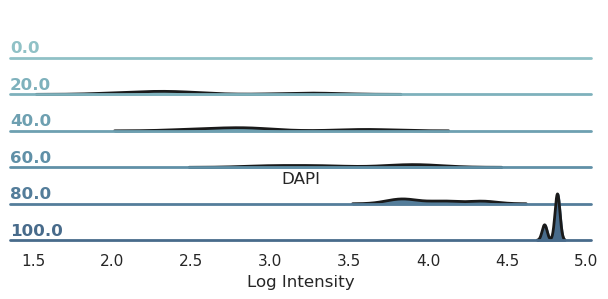

/tmp/ipykernel_813676/3998346922.py:9: RuntimeWarning: divide by zero encountered in log10
  x_values = np.log10(values) if log else values
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

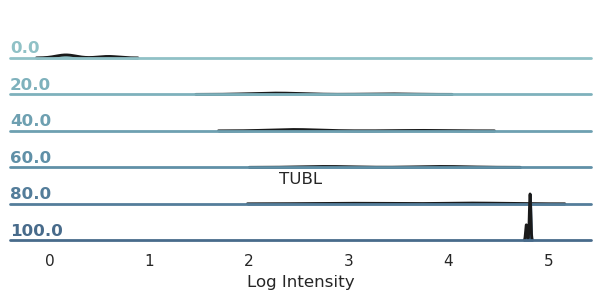

/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plo

<Figure size 640x480 with 0 Axes>

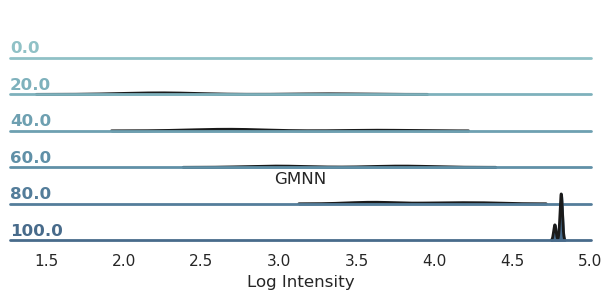

/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plo

<Figure size 640x480 with 0 Axes>

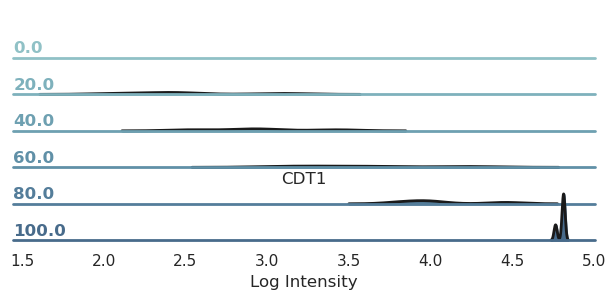

In [33]:
# plot the transformed well percentiles as ridge plots again
channel_ridgeplots(plot_transformed_well_percentiles)

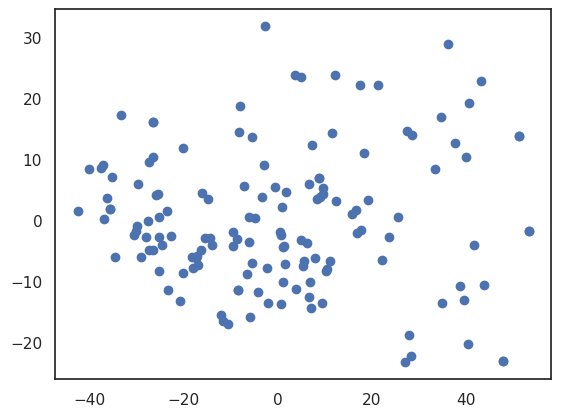

Explained variance ratio: [0.55961536 0.12191344 0.09374729 0.05601251 0.03163757 0.02813005
 0.01967931 0.01533082 0.01027295 0.00875728 0.00618902 0.00608336
 0.00454353 0.00391744 0.00301461]


(PCA(n_components=15), StandardScaler())

In [34]:
# Do PCA on the transformed data and see if it still segregates
percentiles_PCA(transformed_well_percentiles)
# percentiles_PCA(transformed_well_percentiles, color=(np.array(well_path_types) > 0).astype(int))

In [35]:
# rescale the transformed well percentiles to [0, 1] ranges per channel
normalized_well_percentiles = np.copy(transformed_well_percentiles)
print(normalized_well_percentiles.shape)
for i in range(normalized_well_percentiles.shape[0]):
    for j in range(normalized_well_percentiles.shape[1]):
        well_min = normalized_well_percentiles[i][j].min()
        well_max = normalized_well_percentiles[i][j].max()
        if well_min == well_max:
            print(f"well {i} channel {channel_names[j]} has min == max: {well_min}")
            print(normalized_well_percentiles[i][j])
        normalized_well_percentiles[i][j] = (normalized_well_percentiles[i][j] - well_min) / (well_max - well_min)

print(normalized_well_percentiles.min(), normalized_well_percentiles.max())

(142, 4, 256)
0.0 1.0


/tmp/ipykernel_813676/3998346922.py:9: RuntimeWarning: divide by zero encountered in log10
  x_values = np.log10(values) if log else values
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight la

<Figure size 640x480 with 0 Axes>

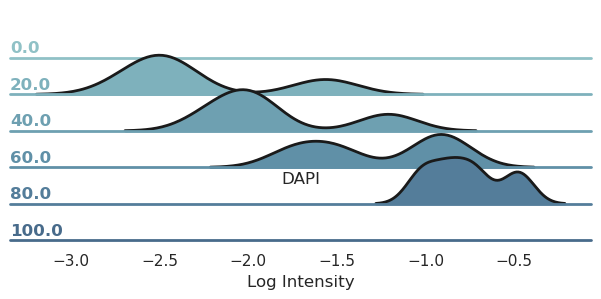

/tmp/ipykernel_813676/3998346922.py:9: RuntimeWarning: divide by zero encountered in log10
  x_values = np.log10(values) if log else values
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight la

<Figure size 640x480 with 0 Axes>

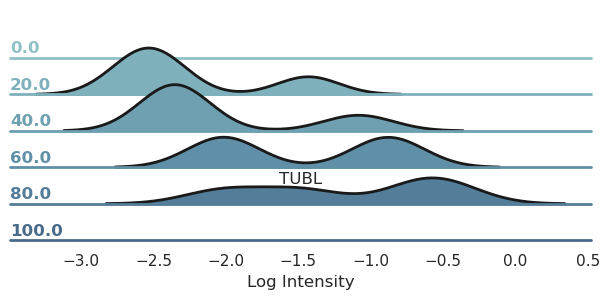

/tmp/ipykernel_813676/3998346922.py:9: RuntimeWarning: divide by zero encountered in log10
  x_values = np.log10(values) if log else values
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight la

<Figure size 640x480 with 0 Axes>

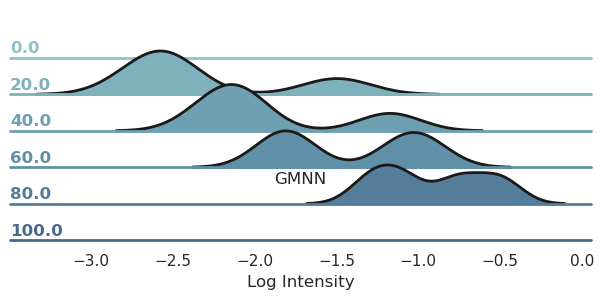

/tmp/ipykernel_813676/3998346922.py:9: RuntimeWarning: divide by zero encountered in log10
  x_values = np.log10(values) if log else values
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight la

<Figure size 640x480 with 0 Axes>

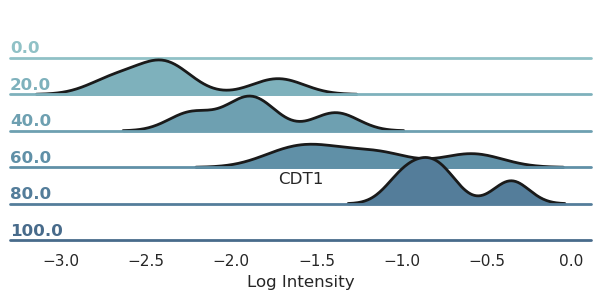

In [36]:
# plot the transformed well percentiles as ridge plots again
plot_normalized_well_percentiles = normalized_well_percentiles[:, :, plot_percentile_indices]
channel_ridgeplots(plot_normalized_well_percentiles)

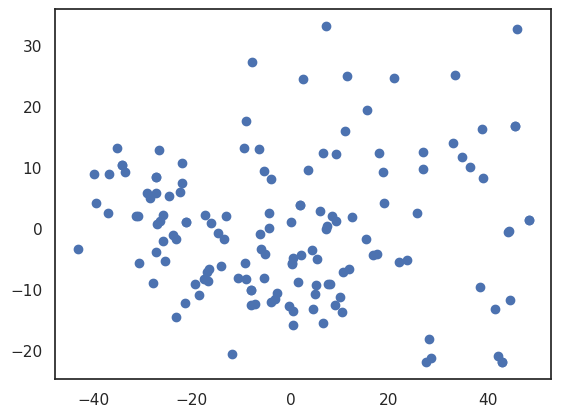

Explained variance ratio: [0.5357597  0.12750892 0.08653689 0.06747555 0.03719803 0.03083419
 0.01917256 0.01683892 0.0125383  0.00829826 0.00704919 0.00631133
 0.00463465 0.00424577 0.00345166]


(PCA(n_components=15), StandardScaler())

In [37]:
# do a PCA on the normalized well percentiles
# percentiles_PCA(normalized_well_percentiles, color=(np.array(well_path_types) > 0).astype(int))
percentiles_PCA(normalized_well_percentiles)

In [38]:
# write normalized well percentiles to disk
np.save(data_folder / "normalized_well_percentiles.npy", normalized_well_percentiles)